## 부탁 드립니다!

본 자료는 패스트캠퍼스 RAG 비법노트 강의에서 유료 강의로 제공되는 자료입니다. 

따라서, 제공된 코드를 사용하여 개발하는 것은 얼마든지 가능합니다만,

**제 3자 에게 무단배포, 웹에 소스코드 게재 및 배포는 금지**하고 있다는 점 부디 양해해 주시기 바랍니다.

개발 및 학습 목적으로만 활용해 주세요. 많은 도움이 되었으면 좋겠습니다. 늘 감사드립니다.

## 환경 설정


In [55]:
from dotenv import load_dotenv

load_dotenv()

True

In [56]:
from langchain_teddynote import logging

logging.langsmith("TeddyNote-Parser", set_enable=False)

LangSmith 추적을 하지 않습니다.


## 이전 단계까지의 내용 재사용

### `upstage_parser_graph` 생성

- `batch_size`: 한번에 처리할 페이지 수
- `test_page`: 테스트할 페이지 번호
- `verbose`: 디버깅 메시지 출력 여부


In [57]:
from layoutparse.teddynote_parser import create_upstage_parser_graph

# 그래프 생성
upstage_parser_graph = create_upstage_parser_graph(
    batch_size=30, test_page=None, verbose=True
)

### `upstage_parser_graph` 사용

- `filepath`: 분석할 PDF 파일의 경로

In [58]:
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph

# 옵션 설정
config = RunnableConfig(
    recursion_limit=300,
    configurable={"thread_id": str(uuid.uuid4())},
)

# filepath: 분석할 PDF 파일의 경로
inputs = {
    "filepath": "data/argus-bitumen.pdf",
}

stream_graph(upstage_parser_graph, inputs, config=config)

[SplitPDFNode] 파일의 전체 페이지 수: 21 Pages.
[SplitPDFNode] 분할 PDF 생성: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Start Parsing: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Finished Parsing in 19.54 seconds
[PostDocumentParseNode] Total Post-processed Elements: 465
[PostDocumentParseNode] Total Cost: $0.21


In [59]:
# 추출된 요소들을 확인합니다
elements = upstage_parser_graph.get_state(config).values["elements_from_parser"]
elements[-20:]

[{'category': 'paragraph',
  'content': {'html': "<br><p id='445' data-category='paragraph' style='font-size:14px'>ARGUS, the ARGUS logo, ARGUS MEDIA, INTEGER,<br>ARGUS BITUMEN , other ARGUS publication titles<br>and ARGUS index names are trademarks of Argus<br>Media Limited.<br>Visit www.argusmedia.com/Ft/trademarks for<br>more information.</p>",
   'markdown': 'ARGUS, the ARGUS logo, ARGUS MEDIA, INTEGER,\nARGUS BITUMEN , other ARGUS publication titles\nand ARGUS index names are trademarks of Argus\nMedia Limited.\nVisit www.argusmedia.com/Ft/trademarks for\nmore information.',
   'text': 'ARGUS, the ARGUS logo, ARGUS MEDIA, INTEGER,\nARGUS BITUMEN , other ARGUS publication titles\nand ARGUS index names are trademarks of Argus\nMedia Limited.\nVisit www.argusmedia.com/Ft/trademarks for\nmore information.'},
  'coordinates': [{'x': 0.35, 'y': 0.6126},
   {'x': 0.5765, 'y': 0.6126},
   {'x': 0.5765, 'y': 0.67},
   {'x': 0.35, 'y': 0.67}],
  'id': 445,
  'page': 20},
 {'category': 'para

## Export 처리 로직 구성

이전 단계의 State 를 재사용하기 때문에 **모듈 단위로 이어서 개발하기가 용이**합니다.

In [60]:
from langgraph.graph import StateGraph, END
from layoutparse.state import ParseState
import layoutparse.export as export
from langchain_teddynote.graphs import visualize_graph


def create_export_graph(
    ignore_new_line_in_text=True,
    show_image_in_markdown=False,
    verbose=True,
    visualize=False,
):
    """
    문서 내보내기를 위한 그래프를 생성하는 함수입니다.

    Args:
        ignore_new_line_in_text (bool): 텍스트에서 줄바꿈을 무시할지 여부
        show_image_in_markdown (bool): 마크다운에 이미지를 표시할지 여부
        verbose (bool): 상세 로그를 출력할지 여부
        visualize (bool): 그래프를 시각화할지 여부

    Returns:
        StateGraph: 컴파일된 내보내기 그래프
    """
    # 후처리 워크플로우를 생성합니다
    export_workflow = StateGraph(ParseState)

    # 이미지 내보내기 노드를 생성합니다
    export_image = export.ExportImage(verbose=verbose)
    # HTML 내보내기 노드를 생성합니다
    export_html = export.ExportHTML(
        ignore_new_line_in_text=ignore_new_line_in_text, verbose=verbose
    )
    # 마크다운 내보내기 노드를 생성합니다
    export_markdown = export.ExportMarkdown(
        ignore_new_line_in_text=ignore_new_line_in_text,
        show_image=show_image_in_markdown,
        verbose=verbose,
    )
    # CSV 테이블 내보내기 노드를 생성합니다
    export_table_csv = export.ExportTableCSV(verbose=verbose)

    # 각 내보내기 노드를 워크플로우에 추가합니다
    export_workflow.add_node("export_image", export_image)
    export_workflow.add_node("export_html", export_html)
    export_workflow.add_node("export_markdown", export_markdown)
    export_workflow.add_node("export_table_to_csv", export_table_csv)

    # 이미지 노드에서 다른 노드로의 연결을 설정합니다
    export_workflow.add_edge("export_image", "export_html")
    export_workflow.add_edge("export_image", "export_markdown")
    export_workflow.add_edge("export_image", "export_table_to_csv")

    # 각 노드에서 종료 지점으로의 연결을 설정합니다
    export_workflow.add_edge("export_html", END)
    export_workflow.add_edge("export_markdown", END)
    export_workflow.add_edge("export_table_to_csv", END)

    # 워크플로우의 시작점을 이미지 내보내기로 설정합니다
    export_workflow.set_entry_point("export_image")

    # 워크플로우를 컴파일하고 필요시 시각화합니다
    export_graph = export_workflow.compile()
    if visualize:
        visualize_graph(export_graph)
    return export_graph

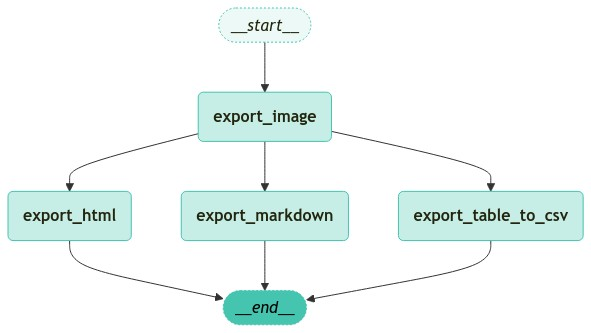

In [61]:
# export 그래프를 생성합니다
export_graph = create_export_graph(show_image_in_markdown=True, visualize=True)

In [62]:
# 이전 단계의 State 를 조회합니다
previous_state = upstage_parser_graph.get_state(config).values

In [63]:
# 이전 단계의 State 를 복사합니다
inputs = previous_state.copy()

# 그래프를 실행합니다
stream_graph(export_graph, inputs, config=config)

## Parent Graph 구성

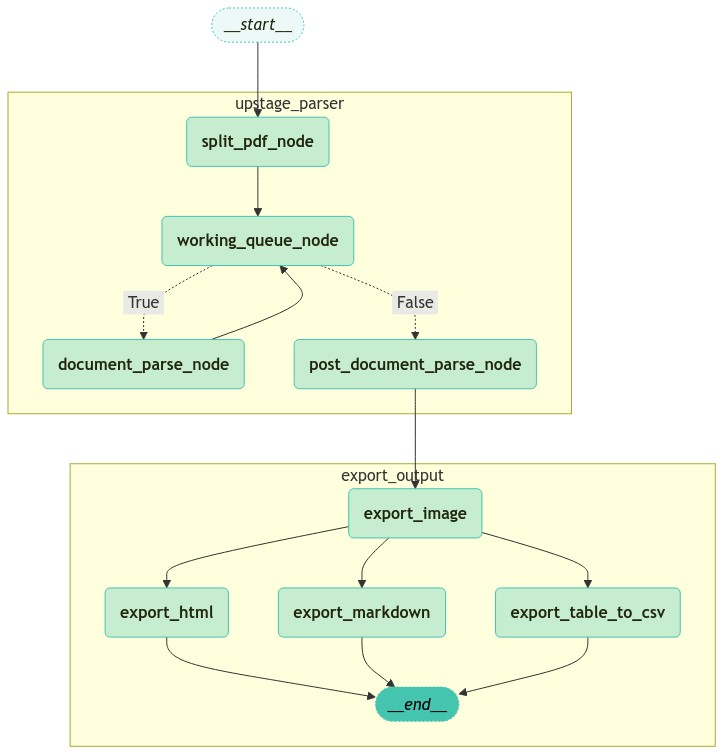

In [65]:
# 체크포인트 저장을 위한 MemorySaver를 임포트합니다
from langgraph.checkpoint.memory import MemorySaver

"""
전체 문서 처리 워크플로우를 구성하는 부분입니다.
업스테이지 파서와 내보내기 기능을 연결하여 하나의 그래프로 만듭니다.
"""

# StateGraph를 사용하여 전체 워크플로우의 뼈대를 생성합니다
parent_workflow = StateGraph(ParseState)

# 업스테이지 파서 노드를 워크플로우에 추가합니다 - PDF 파싱을 담당합니다
parent_workflow.add_node("upstage_parser", upstage_parser_graph)
# 내보내기 노드를 워크플로우에 추가합니다 - 파싱된 결과를 다양한 형식으로 저장합니다
parent_workflow.add_node("export_output", export_graph)

# 파서에서 내보내기로 데이터가 흐르도록 엣지를 연결합니다
parent_workflow.add_edge("upstage_parser", "export_output")

# 워크플로우의 시작점을 파서로 지정합니다
parent_workflow.set_entry_point("upstage_parser")

# 메모리 체크포인터를 사용하여 워크플로우를 컴파일합니다
parent_graph = parent_workflow.compile(checkpointer=MemorySaver())

# 생성된 그래프를 시각화하여 확인합니다 (xray 옵션으로 상세 정보 표시)
visualize_graph(parent_graph, xray=True)

In [66]:
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph

# 옵션 설정
config = RunnableConfig(
    recursion_limit=300,
    configurable={"thread_id": str(uuid.uuid4())},
)

# filepath: 분석할 PDF 파일의 경로
inputs = {
    "filepath": "data/argus-bitumen.pdf",
}

# 그래프를 실행합니다
stream_graph(parent_graph, inputs, config=config)

[SplitPDFNode] 파일의 전체 페이지 수: 21 Pages.
[SplitPDFNode] 분할 PDF 생성: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Start Parsing: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Finished Parsing in 22.36 seconds
[PostDocumentParseNode] Total Post-processed Elements: 465
[PostDocumentParseNode] Total Cost: $0.21
[ExportMarkdown] 마크다운 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/argus-bitumen.md
[ExportHTML] HTML 파일이 성공적으로 생성되었습니다: data/argus-bitumen.html
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_0_Index_10.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_0_Index_14.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_1_Index_26.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-B

In [67]:
# 추출된 요소들을 확인합니다
snapshot = parent_graph.get_state(config).values
snapshot["elements_from_parser"]